In [1]:
import salem as sa
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyproj import Proj
import numpy as np
import pandas as pd
from importlib import reload
import darwin
reload(darwin)

<module 'darwin' from '/home/ben/projects/darwin/darwin.py'>

In [2]:
basepath = Path('/home/ben/data/GAR/')

In [3]:
color_map = LinearSegmentedColormap.from_list(
    "mycmap",
    ["white", "steelblue", "c", "khaki", "orange", "orangered", "r", "darkred"],
)

def plot_map(ax, ds, model, cmap, scalebar=False):
    smap = ds.salem.get_map(data=model, cmap=cmap, vmin=0, vmax=1020)
    x, y = smap.grid.transform(lons, lats)
    smap.set_shapefile(countries=False)
    smap.set_lonlat_contours(xinterval=1)
    if scalebar:
        smap.set_scale_bar(location=(0.85, 0.08))
    smap.visualize(addcbar=False)
    return smap

In [4]:
def remove_nonalphanumerics(string: str) -> str:
    return "".join(ch for ch in string if ch.isalnum())

In [5]:
grid = sa.mercator_grid(center_ll=(-90, 0), extent=(100000, 100000))
oceans = sa.read_shapefile(sa.get_demo_file('ne_50m_ocean.shp'),
                              cached=True)
grid

<salem.Grid>
  proj: +datum=WGS84 +k=0.9996 +lat_0=0 +lon_0=-90 +no_defs+proj=tmerc +units=m +x_0=0 +y_0=0
  pixel_ref: corner
  origin: lower-left
  (nx, ny): (600, 600)
  (dx, dy): (166.66666666666666, 166.66666666666666)
  (x0, y0): (-50000.0, -50000.0)

In [6]:
reload(darwin)
datasets = {}
var = 'ws10'
paths = {
    # 'tropical': f'rc_trop_ls_tutorial/rc_trop_ls_tutorial_d02km_d_2d_{var}_2022.nc',
    'MM': f'rc_trop_ls_MM/rc_trop_ls_MM_d02km_d_2d_{var}_2022.nc',
    # 'Thompson': f'rc_trop_ls_TG/rc_trop_ls_TG_d02km_d_2d_{var}_2022.nc',
    # 'Kain-Fritsch (KF)': f'rc_trop_ls_KF/rc_trop_ls_KF_d02km_d_2d_{var}_2022.nc',
    # 'KF with kfeta-trigger': f'rc_trop_ls_KF_kfeta-trigger/rc_trop_ls_KF_kfeta-trigger_d02km_d_2d_{var}_2022.nc',
    # 'KF Cumulus Potential': f'rc_trop_ls_KFCuP/rc_trop_ls_KFCuP_d02km_d_2d_{var}_2022.nc',
    # 'Grell 3D': f'rc_trop_ls_G3D/rc_trop_ls_G3D_d02km_d_2d_{var}_2022.nc',
    # 'MYNN': f'rc_trop_ls_MYNN/rc_trop_ls_MYNN_d02km_d_2d_{var}_2022.nc',
    # 'MYNN-TG': f'rc_trop_ls_MYNN-TG/rc_trop_ls_MYNN-TG_d02km_d_2d_{var}_2022.nc',
    # 'KF-TG': f'rc_trop_ls_KF-TG/rc_trop_ls_KF-TG_d02km_d_2d_{var}_2022.nc',
    # 'KF-TG-MM5': f'rc_trop_ls_KF-TG-bpl/rc_trop_ls_KF-TG-bpl_d02km_d_2d_{var}_2022.nc',
    # 'tropical': f'rc_trop_ls_vert43/rc_trop_ls_vert43_d02km_d_2d_{var}_2022.nc',
}
for key, value in paths.items():
    datasets[key] = darwin.open_experiment(from_path=basepath / value)
    datasets[key]['experiment'] = value.split('/')[0]
    datasets[key]['wrf_product'] = datasets[key]['wrf_product'].sel(time=slice('2022-04-01', '2022-04-30'))


Getting variable name translations
Adding measurements to dataset


Getting variable name translations


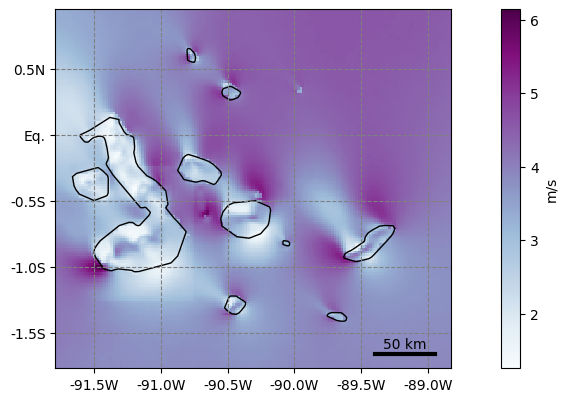

In [7]:
reload(darwin)
aggregation='mean'

for index, key in enumerate(datasets):
    fig, ax = plt.subplots(figsize=(6,5), sharex=True, sharey=True, )
    ds = datasets[key].copy()
    ds['wrf_product'] = ds.remove_boundaries(40)
    ds['experiment']
    ds.plot_map(ax=ax, aggregation=aggregation, save=False, stations=False, cbar=True, unit='m/s', cmap='coolwarm',)
    # ax.set_title(key)
    plt.savefig(f"{ds.experiment}_{ds.varname.lower()}_{aggregation.lower()}_map.png")
    plt.show()

AttributeError: 'Dataset' object has no attribute 'prcp'

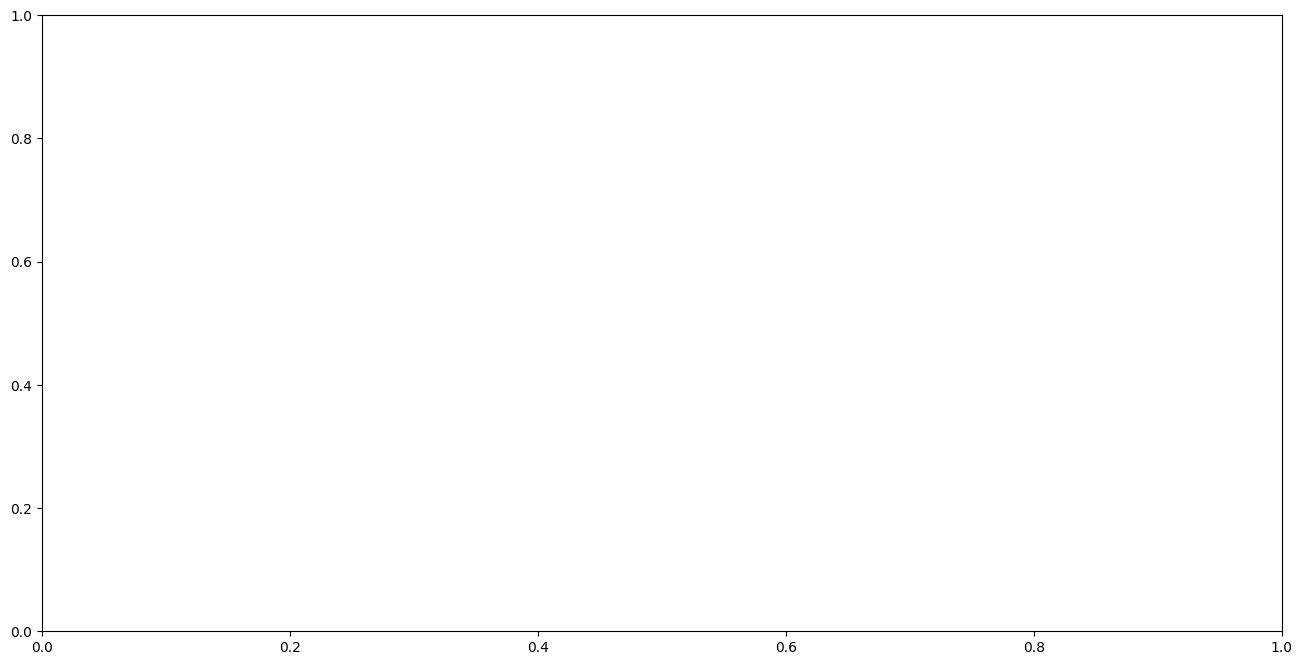

In [8]:
fig, ax = plt.subplots(figsize=(16,8))

for index, key in enumerate(datasets):
    ds = datasets[key].wrf_product.prcp.salem.roi(shape=oceans, all_touched=False)
    ax.plot(ds.time, (24 * ds.mean(axis=(1,2)).cumsum()), label=key)

ax.grid()
ax.set_ylabel('precipitation over land in mm')
plt.tight_layout()
plt.legend()
plt.savefig("schemata_prcp-land_cumsum.png")
plt.show()

In [ ]:
mask_thompson = thompson.prcp.salem.roi(shape=oceans, all_touched=True)
mask_thompson.mean(axis=(1,2)).cumsum().plot(ax=ax, label="Thompson Graupel", color='magenta')

mask_trop = trop.prcp.salem.roi(shape=oceans, all_touched=True)
mask_trop.mean(axis=(1,2)).cumsum().plot(ax=ax, label="New Tiedtke (tropical)", color='k')
#
plt.ylabel('average precipitation in mm')
ax.legend()
# plt.savefig("domain_sizes_prcp_land.png")
plt.show()